In [1]:
from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Helper fuctions

In [2]:
def load_csv(filename):
    file = open(filename, "r", encoding="utf-8")
    experiments = []
    headers = []
    reader = csv.reader(file)
    for i, lines in enumerate(reader):
        if i == 0:
            #headers = [e for e in lines[0].split(";")]
            h = lines[0].split(";")
            headers.append(h)
        else:
            tmp = lines[0].split(";")
            for j in range(0,len(tmp)):
                if (j != 0 and j != 1879):
                    tmp[j] = float(tmp[j])
                else:
                    continue
            #tmp = [float(tmp[j]) for j in range(0,len(tmp)) if (j!=0 and j!=1879)] #This removes two entries, dunno why. 
            experiments.append(tmp)
    file.close()
    return headers, experiments

def column_extraction(data_list,column_number): #columns start counting in 0
    col = []
    for i in range(0,len(experiments)):
        dato = experiments[i][column_number]
        col.append(dato)
    return col   

## Load both data sets for comparision

In [3]:
# Loading compound library
my_sheet = 'SPECS_drug_repurp_set' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = r'/home/jovyan/covid-data/SPECS_drug_repurp_set.xlsx'# change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)
#print(df.head()) # shows headers with top 5 rows
library_compound_ids = df[["Compound ID"]].copy()
library_compound_ids.rename(columns = {'Compound ID':'ID_library'}, inplace = True)

In [4]:
#Loading Maris' data
headers, experiments =load_csv('/home/jovyan/covid-data/dalia_MeanFeaturesPerWell_BatchA.csv')
#Column 1879 contains the compound ID
screening_compound_ids = pd.DataFrame(column_extraction(experiments,1879), columns=['ID_Screening'])

In [5]:
print(f'The library has {len(library_compound_ids)} compounds')
print(f'The experiment has {len(screening_compound_ids)} compounds')

The library has 5280 compounds
The experiment has 6065 compounds


### Cleaning Library's compounds

In [6]:
# Removing compunds with ID "Problem with structure"
problem = library_compound_ids.loc[library_compound_ids['ID_library']=='Problem with structure']
problem

,ID_library
3471,Problem with structure
5185,Problem with structure


In [7]:
#Check that we did not miss information
library_compound_ids_2 = library_compound_ids.copy().drop([3471, 5185])
print(f'The library has now {len(library_compound_ids_2)} compounds')

The library has now 5278 compounds


In [8]:
library_compound_ids_2 = library_compound_ids_2.copy().groupby('ID_library').size().sort_values(ascending=False).to_frame() #Count the elements in each group and sort
library_compound_ids_2.rename(columns = {0:'Count'}, inplace = True)
unique_id_lib_count = library_compound_ids_2.copy().reset_index()
a = unique_id_lib_count[unique_id_lib_count['Count'] >1]
print(f'Printing repeated compounds {a}')
repeated_compounds = unique_id_lib_count['ID_library'][unique_id_lib_count['Count'] >1].tolist()#Storing

Printing repeated compounds    ID_library  Count
0   CBK011558      3
1   CBK011603      3
2   CBK042067      3
3   CBK041250      3
4   CBK000879      3
..        ...    ...
78  CBK200659      2
79  CBK041357      2
80  CBK041430      2
81  CBK041511      2
82  CBK309105      2

[83 rows x 2 columns]


In [9]:
specs = df.copy().drop([3471, 5185])
experiments_df = pd.DataFrame(experiments , columns=headers[0])
#specs.head()
#experiments_df['CompoundID'].head()

In [10]:
count = 0
data = []
for compound in repeated_compounds:
    #aux = experiments_df[experiments_df['CompoundID'].str.contains(compound)]
    aux = experiments_df['Intensity_MeanIntensity_illumMITO_cells'].loc[experiments_df['CompoundID'] == compound]
    aux.columns = ['0','Intensity_MeanIntensity_illumMITO_cells']
    data.append(aux['Intensity_MeanIntensity_illumMITO_cells'].tolist())
    #plt.boxplot(aux)
    count += 1
    #if count == 5:
        #break

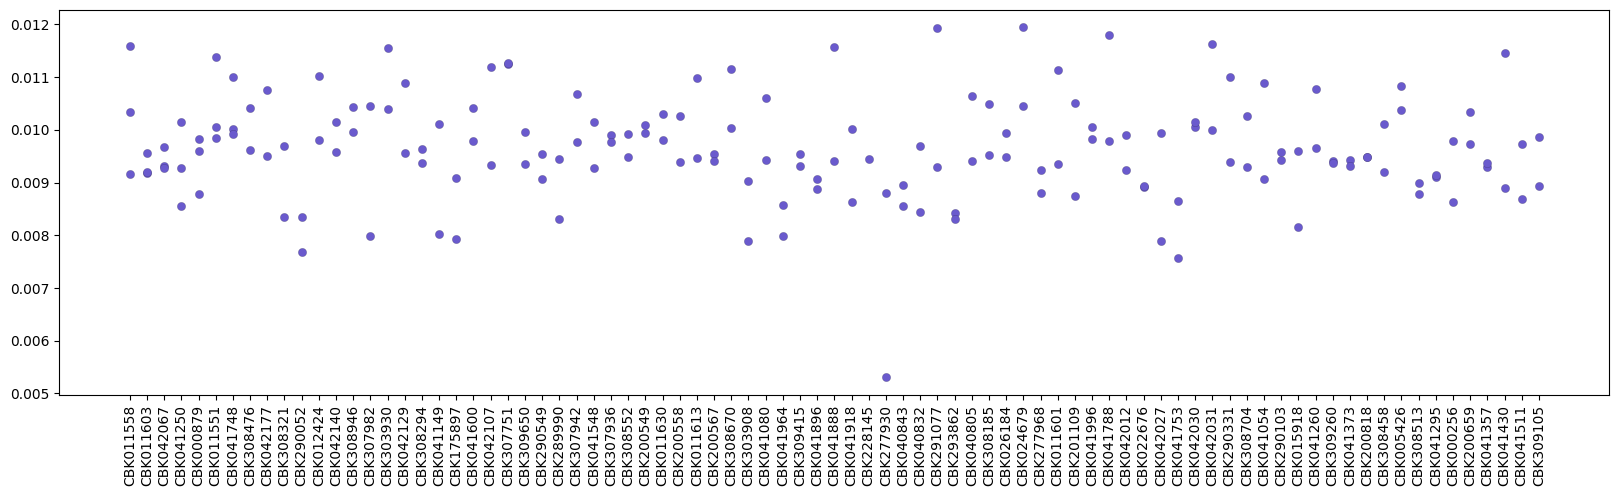

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
for xe, ye in zip(repeated_compounds, data):
    ax.scatter([xe] * len(ye), ye,edgecolor='black', linewidth=0.1, facecolor='slateblue')

plt.xticks(rotation=90)
plt.show()

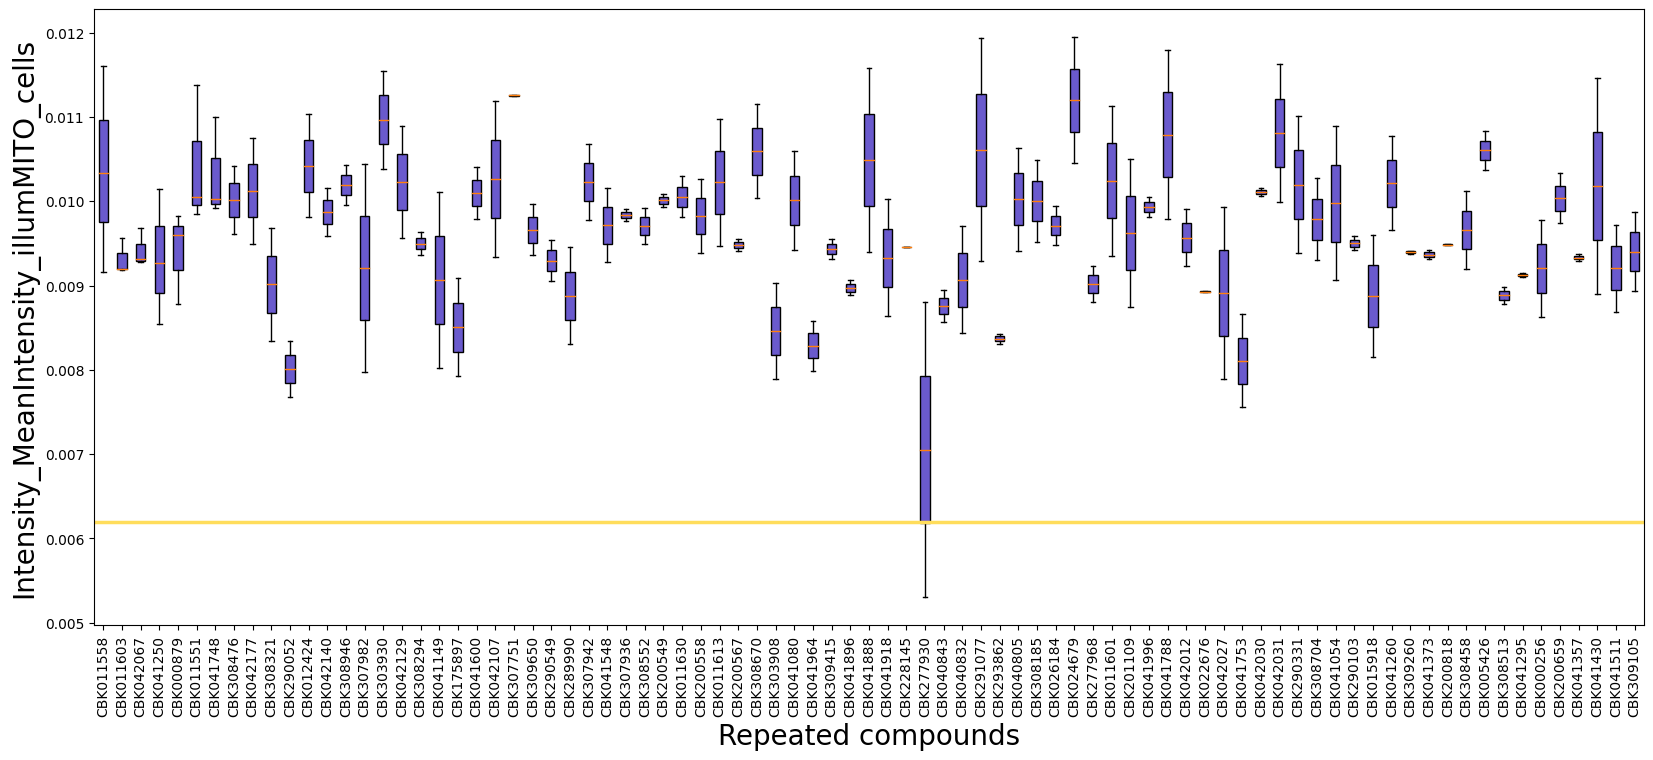

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
bp = ax.boxplot(data, labels=repeated_compounds,patch_artist=True)
#Changing colour
for patch, color in zip(bp['boxes'], ['slateblue']*len(repeated_compounds)):
    patch.set_facecolor(color)
    
ax.set_ylabel('Intensity_MeanIntensity_illumMITO_cells', color="black", fontsize=20)   
ax.set_xlabel('Repeated compounds', color="black", fontsize=20)    
plt.axhline(y=0.0062, color=(1, .867, .357), linestyle='-', lw = 2.5)
plt.xticks(rotation=90)
plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()